## CMPN403 Programming Assignment
#### Team:
| Name                     | ID       | Day       | Tutorial Time |
|--------------------------|----------|-----------|--------------|
| Yomna Osama Hussien     | 1190203 | Wednesday | 8:00 - 11:00 |
| Mohamed Hassan Mohamed  | 1190118 | Sunday    | 4:00 - 7:00  |


### Imports

In [101]:
import json
import graphviz
import numpy as np
from typing import *
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Utility functions

In [102]:
def verify_regex(regex: str) -> bool:
    """
    Verify if the regex is valid.

    Args:
        regex (str): The regular expression.

    Returns:
        bool: True if the regex is valid, False otherwise.
    """
    stack = []
    # loop through the regex and get the character at each index
    for index in range(len(regex)):
        if regex[index] == '[':
            stack.append(regex[index])
        elif regex[index] == ']':
            if not stack or stack.pop() != '[':
                return False
        elif regex[index] == '(':
            stack.append(regex[index])
        elif regex[index] == ')':
            if not stack or stack.pop() != '(':
                return False
        elif regex[index] == '-':
            # check if the previous character is a alphanumeric character
            if index-1 < 0 or index+1 >= len(regex):
                return False
            if not regex[index-1].isalnum():
                return False
            # check if the next character is a alphanumeric character
            if not regex[index+1].isalnum():
                return False
        elif regex[index] == '|':
            # check if the next character is a alphanumeric character or a bracket or a parenthesis
            if index+1 >= len(regex):
                return False
            if not regex[index+1].isalnum() and regex[index+1] != '(' and regex[index+1] != '[' and regex[index+1] != '.':
                return False
            if index-1 < 0:
                return False
            if regex[index-1] == '[' or regex[index-1] == '(':
                return False
    return not stack

def get_subregex(regex: str, i: int) -> str:
    """
    Get the subregex from the regex string inside the parenthesis.

    Args:
        regex (str): The regular expression.
        i (int): Index of the parenthesis.

    Returns:
        str: The subregex.
    """
    depth = 1
    subregex = regex[i+1:]

    for j, char in enumerate(subregex):
        if char == '(':
            depth += 1
        elif char == ')':
            depth -= 1
        if depth == 0:
            subregex = subregex[:j]
            break
    return subregex

def json_write(states: Dict[str, Dict], filename: str) -> None:
    """
    Write the states dictionary to a JSON file.

    Args:
        states (Dict[str, Dict]): Dictionary representing the states and transitions of the FSM.
        filename (str): Name of the JSON file.
    """
    if not filename.endswith('.json'):
        filename += '.json'
        
    with open(filename, 'w') as file:
        json.dump(states, file, indent=4)

def draw_FSM(json_file: str, label: str) -> graphviz.Digraph:
    """
    Read a JSON file containing a finite state machine (FSM) and draw it using Graphviz.

    Args:
        json_file (str): Path to the JSON file.
        label (str): Label for the FSM.

    Returns:
        graphviz.Digraph: Graphviz Digraph object representing the FSM.
    """
    with open(json_file, 'r') as file:
        fsm: Dict[str, Dict] = json.load(file)

    dot = graphviz.Digraph(comment=label)
    dot.node('startingStateH', 'startingStateH', style='invis')
    
    for key in fsm.keys():
        if key == 'startingState':
            continue
        if fsm[key]['isTerminatingState']:
            dot.node(key, key, shape='doublecircle')
        else:
            dot.node(key, key)
    
    for key in fsm.keys():
        if key == 'startingState':
            continue
        for symbol in fsm[key].keys():
            if symbol == 'isTerminatingState':
                continue
            if label == 'NFA':
                for next_state in fsm[key][symbol]:
                    if symbol == 'epsilon':
                        symbol = 'ε'
                    dot.edge(key, next_state, label=symbol)
            else:
                next_state = fsm[key][symbol]
                dot.edge(key, next_state, label=symbol)
    
    dot.edge('startingStateH', fsm['startingState'])

    return dot

def save_image(json_file: str, fileName: str, label: str) -> None:
    """
    Draw the FSM and save it as an image.

    Args:
        json_file (str): Path to the JSON file.
        fileName (str): Name of the output image file.
        label (str): Label for the FSM.
    """
    dot = draw_FSM(json_file, label)
    dot.format = 'png'
    dot.render(fileName)

### Regex to NFA

The following class is used to convert a regular expression to an NFA.

Supported operations:
- Concatenation
- Alternation
- Kleene Star
- Kleene Plus
- Optional


In [103]:
class NFA:
    def __init__(self) -> None:
        """
        Constructor for the NFA class.
        """
        self.start_state: int = 0
        self.next_state: int = 0
        self.prev_state: int = 0
        self.prev_start: int = 0
        self.states: Dict[str, Dict] = {"startingState": "S0", "S0": {"isTerminatingState": False}}

    def generate_NFA(self, regex: str, filename: str) -> Dict[str, Dict]:
        """
        Generate the NFA for the given regex and write it to a JSON file.

        Args:
            regex (str): The regular expression.
            filename (str): The name of the output JSON file.

        Returns:
            Dict[str, Dict]: Dictionary representing the states and transitions of the NFA.
        """
        i: int = self.build_NFA(regex)
        
        if i == len(regex):
            self.states["S" + str(self.next_state)]["isTerminatingState"] = True
            self.states.update({"startingState": ("S" + str(self.prev_start))})

        json_write(self.states, filename)
        
        return self.states
    
    def build_NFA(self, regex: str) -> int:
        """
        Build the NFA for the given regex.

        Args:
            regex (str): The regular expression.

        Returns:
            int: The index in the regex where building stopped.
        """
        i: int = 0
        while i < len(regex):
            if regex[i] == '(':
                subregex = get_subregex(regex, i)

                start_state = self.start_state
                next_state = self.next_state
                prev_state = self.prev_state
                prev_start = self.prev_start

                sub_value = self.next_state + 1
                self.start_state = sub_value
                self.next_state = sub_value
                self.prev_state = sub_value
                self.prev_start = sub_value

                self.states.update({"S" + str(self.next_state): {"isTerminatingState": False}})
                self.build_NFA(subregex)

                if "ε" in self.states["S" + str(next_state)].keys():
                    self.states["S" + str(next_state)]["ε"].append("S" + str(self.prev_start))
                else:
                    self.states["S" + str(next_state)]["ε"] = ["S" + str(self.prev_start)]

                self.prev_state = self.prev_start
                self.prev_start = prev_start
                self.start_state = self.next_state

                i += len(subregex) + 2
                
            elif regex[i] == '|':
                i += 1

                self.states.update({"S" + str(self.next_state + 1): {"isTerminatingState": False}})

                start_state = self.start_state
                next_state = self.next_state
                prev_state = self.prev_state
                prev_start = self.prev_start

                alt_value = self.next_state + 1
                self.start_state = alt_value
                self.next_state = alt_value
                self.prev_state = alt_value
                self.prev_start = alt_value
                
                self.build_NFA(regex[i:])

                alt_start_state = self.start_state
                alt_next_state = self.next_state
                alt_prev_state = self.prev_state
                alt_prev_start = self.prev_start

                self.start_state = start_state
                self.next_state = next_state
                self.prev_state = prev_state
                self.prev_start = prev_start

                i += len(regex[i:])

                self.states.update({"S" + str(alt_next_state + 1): {"isTerminatingState": False}})
                
                if 'ε' in self.states["S" + str(alt_next_state + 1)].keys():
                    self.states["S" + str(alt_next_state + 1)]["ε"].append("S" + str(self.prev_start))
                    self.states["S" + str(alt_next_state + 1)]["ε"].append("S" + str(alt_prev_start))
                else:
                    self.states["S" + str(alt_next_state + 1)]["ε"] = ["S" + str(self.prev_start), "S" + str(alt_prev_start)]

                self.states.update({"S" + str(alt_next_state + 2): {"isTerminatingState": False}}) 

                if 'ε' in self.states["S" + str(alt_next_state)].keys():
                    self.states["S" + str(alt_next_state)]["ε"].append("S" + str(alt_next_state + 2))
                else:
                   self.states["S" + str(alt_next_state)]["ε"] = ["S" + str(alt_next_state + 2)]

                if 'ε' in self.states["S" + str(self.next_state)].keys():
                    self.states["S" + str(self.next_state)]["ε"].append("S" + str(alt_next_state + 2))
                else:
                    self.states["S" + str(self.next_state)]["ε"] = ["S" + str(alt_next_state + 2)] 

                self.prev_start = alt_next_state + 1
                self.next_state = alt_next_state + 2
                self.prev_state = alt_next_state + 1
                self.start_state = alt_next_state
            elif regex[i] == '[':
                substring, end = self.get_range_substring(regex, i)
                self.start_state, self.next_state, self.prev_state, self.states = self.add_state(substring, self.start_state, self.next_state, self.prev_state, self.states, i, True)
                i = end 

            else:
                self.start_state, self.next_state, self.prev_state, self.states = self.add_state(regex, self.start_state, self.next_state, self.prev_state, self.states, i)
                i += 1
        return i
    
    def add_state(self, regex: str, start_state: int, next_state: int,prev_state: int, states: Dict[str, Dict], i: int, isRange: bool = False) -> Tuple[int, int, Dict[str, Dict]]:
        """
        Add a state to the NFA.

        Args:
            regex (str): The regular expression.
            start_state (int): The starting state.
            next_state (int): The next state.
            prev_state (int): The previous state.
            states (Dict[str, Dict]): Dictionary representing the states and transitions of the NFA.
            i (int): Index in the regex.
            isRange (bool, optional): Indicates if the regex is a range. Defaults to False.

        Returns:
            Tuple[int, int, Dict[str, Dict]]: The updated start state, next state, and states dictionary.
        """
        next_state += 1
        if isRange:
            return self.handle_range(start_state, next_state, prev_state, states, regex)
        
        if(regex[i] == '+'):
            return self.handle_positive_closure(start_state, next_state, prev_state, states)
        
        if regex[i] == '*':
            return self.handle_zero_or_more(start_state, next_state, prev_state, states)
        
        if regex[i] == '?':
           return self.handle_zero_or_one(start_state, next_state, prev_state, states)
        
        if regex[i] in states["S" + str(start_state)]:
            states["S" + str(start_state)][regex[i]].append("S" + str(next_state))
        else:
            states["S" + str(start_state)][regex[i]] = ["S" + str(next_state)]
        
        states["S" + str(next_state)] = {"isTerminatingState": False}
        prev_state = start_state
        start_state = next_state

        return start_state, next_state, prev_state, states

    def get_range_substring(self, regex: str, i: int) -> Tuple[str, int]:
        """
        Get the substring inside the square brackets.

        Args:
            regex (str): The regular expression.
            i (int): Index in the regex.

        Returns:
            Tuple[str, int]: The substring and the index where the range ends.
        """
        subString = ""
        end = i
        regex = regex[i:]       # discard part before bracket (but takes the bracket itself)
        for j in range(len(regex)):
            if regex[j] == ']':             # matching first closed bracket
                subString = regex[:j+1]       # discard part after bracket (but takes the bracket itself)
                end = i+j+1
                return subString, end
        
        return subString, end

    def handle_range(self, start_state: int, next_state: int, prev_state: int, states: Dict[str, Dict], substring: str) -> Tuple[int, int,int, Dict[str, Dict]]:
        """
        Handle the range in the given regex.

        Args:
            start_state (int): The starting state.
            next_state (int): The next state.
            prev_state (int): The previous state.
            states (Dict[str, Dict]): Dictionary representing the states and transitions of the NFA.
            substring (str): The substring representing the range.

        Returns:
            Tuple[int, int,int, Dict[str, Dict]]: The updated start state, next state, previous state, and states dictionary.
        """
        if substring in states["S" + str(start_state)].keys():
            states["S" + str(start_state)][substring].append("S" + str(next_state))
        else:
            states["S" + str(start_state)][substring] = ["S" + str(next_state)]
        
        states["S" + str(next_state)] = {"isTerminatingState": False}
        prev_state = start_state
        start_state = next_state

        return start_state, next_state, prev_state, states

    def handle_positive_closure(self, start_state: int, next_state: int, prev_state: int, states: Dict[str, Dict]) -> Tuple[int, int,int, Dict[str, Dict]]:
        """
        Handle the positive closure in the given regex.

        Args:
            start_state (int): The starting state.
            next_state (int): The next state.
            prev_state (int): The previous state.
            states (Dict[str, Dict]): Dictionary representing the states and transitions of the NFA.

        Returns:
            Tuple[int, int,int, Dict[str, Dict]]: The updated start state, next state, previous state, and states dictionary.
        """
        states["S" + str(next_state)] = {"isTerminatingState": False}  
        if 'ε' in states["S" + str(start_state)]:
            states["S" + str(start_state)]["ε"].append("S" + str(prev_state))
            states["S" + str(start_state)]["ε"].append("S" + str(next_state))
        else:
            states["S" + str(start_state)]["ε"] = ["S" + str(prev_state), "S" + str(next_state)]
        prev_state = start_state
        start_state = next_state
        return start_state, next_state, prev_state, states
    
    def handle_zero_or_more(self, start_state: int, next_state: int, prev_state: int, states: Dict[str, Dict]) -> Tuple[int, int,int, Dict[str, Dict]]:
        """
        Handle the zero or more (Kleene Star) in the given regex.

        Args:
            start_state (int): The starting state.
            next_state (int): The next state.
            prev_state (int): The previous state.
            states (Dict[str, Dict]): Dictionary representing the states and transitions of the NFA.

        Returns:
            Tuple[int, int,int, Dict[str, Dict]]: The updated start state, next state, previous state, and states dictionary.
        """
        states["S" + str(next_state)] = {"isTerminatingState": False}  
        if 'ε' in states["S" + str(start_state)]:
            states["S" + str(start_state)]["ε"].append("S" + str(prev_state))
            states["S" + str(start_state)]["ε"].append("S" + str(next_state))
        else:
            states["S" + str(start_state)]["ε"] = ["S" + str(prev_state), "S" + str(next_state)]
        
        if 'ε' in states["S" + str(prev_state)]:
            states["S" + str(prev_state)]["ε"].append("S" + str(next_state))
        else:
            states["S" + str(prev_state)]["ε"] = ["S" + str(next_state)]
            
        prev_state = start_state
        start_state = next_state
        return start_state, next_state, prev_state, states
    
    def handle_zero_or_one(self, start_state: int, next_state: int, prev_state: int, states: Dict[str, Dict]) -> Tuple[int, int,int, Dict[str, Dict]]:
        """
        Handle the zero or one (Kleene Plus) in the given regex.

        Args:
            start_state (int): The starting state.
            next_state (int): The next state.
            prev_state (int): The previous state.
            states (Dict[str, Dict]): Dictionary representing the states and transitions of the NFA.

        Returns:
            Tuple[int, int,int, Dict[str, Dict]]: The updated start state, next state, previous state, and states dictionary.
        """
        states["S" + str(next_state)] = {"isTerminatingState": False}  
        if 'ε' in states["S" + str(start_state)]:
            states["S" + str(start_state)]["ε"].append("S" + str(next_state))
        else:
            states["S" + str(start_state)]["ε"] = ["S" + str(next_state)]
        
        if 'ε' in states["S" + str(prev_state)]:
            states["S" + str(prev_state)]["ε"].append("S" + str(next_state))
        else:
            states["S" + str(prev_state)]["ε"] = ["S" + str(next_state)]
        
        prev_state = start_state
        start_state = next_state
        return start_state, next_state, prev_state, states


#### NFA Unit Testing

In [104]:
nfa = NFA()
nfa.generate_NFA("yomna", "literal.json")
save_image("literal.json", "literal", "NFA")

In [105]:
nfa = NFA()
nfa.generate_NFA("amin+", "positiveClosure.json")
save_image("positiveClosure.json", "positiveClosure", "NFA")

In [106]:
nfa = NFA()
nfa.generate_NFA("amin?", "zeroOrOne.json")
save_image("zeroOrOne.json", "zeroOrOne", "NFA")

In [107]:
nfa = NFA()
nfa.generate_NFA("amin*", "zeroOrMore.json")
save_image("zeroOrMore.json", "zeroOrMore", "NFA")

In [108]:
nfa = NFA()
nfa.generate_NFA("aa|b", "Alternate.json")
save_image("Alternate.json", "Alternate", "NFA")

In [109]:
nfa = NFA()
nfa.generate_NFA("[A-Z0-9]", "range.json")
save_image("range.json", "range", "NFA")

In [110]:
nfa = NFA()
nfa.generate_NFA("(www.)", "brackets.json")
save_image("brackets.json", "brackets", "NFA")

### Conversion to DFA

In [111]:
def epsilon_closure(states: Dict[str, Dict], state: str, visited: Set[str] = None) -> Tuple[Set[str], bool]:
    """
    Compute the epsilon closure of a given state in the DFA.

    Args:
        states (Dict[str, Dict]): Dictionary representing the states and transitions of the DFA.
        state (str): The current state to compute the epsilon closure for.
        visited (Set[str], optional): Set of visited states to avoid revisiting. Defaults to None.

    Returns:
        Tuple[Set[str], bool]: Tuple containing the epsilon closure set of states and a boolean indicating if any state in the closure is terminating.
    """
    if visited is None:
        visited = set()
    visited.add(state)
    terminating = states[state].get("isTerminatingState", False)

    for next_state in states[state].get("ε", []):
        if next_state not in visited:
            closure, is_terminating = epsilon_closure(states, next_state, visited)
            visited.update(closure)
            terminating |= is_terminating

    return visited, terminating


In [112]:
def move(states: Dict[str, Dict], state_closure: Set[str], input_symbol: str) -> Tuple[Set[str], bool]:
    """
    Compute the set of states reachable from the current state using the given input symbol.

    Args:
        states (Dict[str, Dict]): Dictionary representing the states and transitions of the DFA.
        state_closure (Set[str]): Set of states representing the epsilon closure of the current state.
        input_symbol (str): Input symbol to transition on.

    Returns:
        Tuple[Set[str], bool]: Tuple containing the set of reachable states and a boolean indicating if any state in the set is terminating.
    """
    terminating = False
    move = set()

    for state in state_closure:
        terminating = terminating or states[state]["isTerminatingState"]
        for key, val in states[state].items():
            if key == input_symbol:
                temp_move = set()  # Temporary set to store the elements
                for v in val:
                    temp_move.add(v)
                    return_move, return_terminating = epsilon_closure(states, v, move)
                    temp_move.update(return_move)
                    terminating = terminating or return_terminating
                move.update(temp_move)  # Update move set after loop
            elif key[0] == "[":
                if input_symbol in range_unfolding(key):
                    temp_move = set()
                    for v in val:
                        temp_move.add(v)
                        return_move, return_terminating = epsilon_closure(states, v, move)
                        temp_move.update(return_move)
                        terminating = terminating or return_terminating
                    move.update(temp_move)

    return move, terminating


def get_reachable_states(states: Dict[str, Dict], state: str) -> Set[str]:
    """
    Recursively find reachable states considering epsilon transitions.

    Args:
        states (Dict): Dictionary containing all states and their transitions.
        state (str): The current state.

    Returns:
        Set[str]: Set of reachable states.
    """
    reachable_states = set([state])

    if isinstance(states[state], list):
        for next_state in states[state]:
            reachable_states.update(get_reachable_states(states, next_state))
    elif isinstance(states[state], str):
        reachable_states.update(get_reachable_states(states, states[state]))

    return reachable_states


def range_unfolding(substring: str) -> str:
    """
    Unfold character ranges in a substring.

    Args:
        substring (str): The substring containing character ranges.

    Returns:
        str: Unfolded substring.
    """
    new_substring = ""
    for i in range(1, len(substring) - 1):  # Skip the brackets []
        if substring[i] == '-' and 1 < i < len(substring) - 2:
            new_substring += range_char(substring[i - 1], substring[i + 1])
        else:
            new_substring += substring[i]
    return new_substring


def range_char(start: str, stop: str) -> str:
    """
    Generate a string of characters from start to stop.

    Args:
        start (str): Start character.
        stop (str): Stop character.

    Returns:
        str: String of characters from start to stop.
    """
    # Return characters from start to stop, exclusive.
    return ''.join(chr(n) for n in range(ord(start) + 1, ord(stop)))


In [113]:
def compare_sets(set1: Set[str], set2: Set[str]) -> bool:
    """
    Compare two sets of strings.

    Args:
        set1 (Set[str]): First set of strings.
        set2 (Set[str]): Second set of strings.

    Returns:
        bool: True if the sets are equal, False otherwise.
    """
    return len(set1) == len(set2) and len(set1.difference(set2)) == 0
              
def convert_nfa_to_dfa(nfa_states: Dict[str, Dict], dfa_states_queue: List[Set[str]], is_start_terminating: bool) -> Dict[str, Dict]:
    """
    Convert an NFA to a DFA.

    Args:
        nfa_states (Dict[str, Dict]): Dictionary representing the states and transitions of the NFA.
        dfa_states_queue (List[Set[str]]): List of sets representing DFA states.
        is_start_terminating (bool): Whether the starting state of the NFA is terminating.

    Returns:
        Dict[str, Dict]: Dictionary representing the states and transitions of the DFA.
    """
    explored_dfa_states = []
    dfa_output_json = {}
    state_counter = 0
    dfa_output_json["startingState"] = "S" + str(state_counter)

    state_name_to_dfa_state_map = {}

    state_name_to_dfa_state_map["S" + str(state_counter)] = dfa_states_queue[0]
    dfa_output_json["S" + str(state_counter)] = {"isTerminatingState": is_start_terminating}

    while dfa_states_queue:
        if dfa_states_queue[0] in explored_dfa_states:
            dfa_states_queue.pop(0)
            continue

        explored_dfa_states.append(dfa_states_queue[0])
        current_dfa_state = dfa_states_queue.pop(0)
        
        inputs = get_inputs(nfa_states, current_dfa_state)

        for input_symbol in inputs:
            move_set, is_terminating = move(nfa_states, current_dfa_state, input_symbol)
            
            new_move_set = True
            for explored_state in explored_dfa_states:
                if compare_sets(explored_state, move_set):
                    new_move_set = False
                    break
            
            if new_move_set:
                dfa_states_queue.append(move_set)

            going_to_state = ""
            coming_from_state = ""
            for key, val in state_name_to_dfa_state_map.items():
                if compare_sets(val, move_set):
                    going_to_state = key

                if compare_sets(val, current_dfa_state):
                    coming_from_state = key

            if going_to_state == "":
                state_counter += 1
                going_to_state = "S" + str(state_counter)
                state_name_to_dfa_state_map[going_to_state] = move_set
                dfa_output_json[going_to_state] = {"isTerminatingState": is_terminating}

            dfa_output_json[coming_from_state].update({input_symbol: going_to_state})

    return dfa_output_json


def get_inputs(states: Dict[str, Dict], dfa_state: Set[str]) -> Set[str]:
    """
    Get the valid inputs for a DFA state.

    Args:
        states (Dict[str, Dict]): Dictionary representing the states and transitions of the NFA.
        dfa_state (Set[str]): Set representing a DFA state.

    Returns:
        Set[str]: Set of valid input symbols.
    """
    valid_inputs = set()

    for state in dfa_state:
        for key, _ in states[state].items():
            if key not in {"isTerminatingState", "ε"}:
                if key.startswith("["):
                    valid_inputs.update(range_unfolding(key))
                else:
                    valid_inputs.add(key)

    return valid_inputs

In [114]:
def infer_character_class(chars: Iterable[str]) -> str:
    """
    Infer the character class from a given set of characters.

    Args:
        chars (Iterable[str]): Iterable of characters.

    Returns:
        str: String representing the inferred character class.
    """
    specials = sorted(char for char in chars if not char.isalnum())
    chars = sorted(char for char in chars if char.isalnum())
    if len(chars) == 0:
        return ''.join(specials)
    ranges = []
    start = end = chars[0]
    for char in chars[1:]:
        if ord(char) == ord(end) + 1:
            end = char
        else:
            ranges.append((start, end))
            start = end = char
    ranges.append((start, end))
    res_rng = []
    res_literal = []
    for start, end in ranges:
        if ord(start) == ord(end):
            res_literal.append(start)
        else:
            res_rng.append(start + '-' + end)
    return ''.join([*res_rng, *res_literal, *specials])

def convert_transitions_to_character_classes(transitions: Dict[str, Dict[str, str]]) -> Dict[str, Dict[str, str]]:
    """
    Convert transitions in a DFA from JSON file to character classes where applicable.

    Args:
        transitions (Dict[str, Dict[str, str]]): Dictionary representing transitions.

    Returns:
        Dict[str, Dict[str, str]]: Dictionary with transitions converted to character classes.
    """
    converted_transitions = {}
    for state, transitions_dict in transitions.items():
        if state == 'startingState':
            converted_transitions[state] = transitions_dict
            continue
        converted_transitions[state] = {}
        state_transitions = {}
        for symbol, next_state in transitions_dict.items():
            if symbol == 'isTerminatingState':
                converted_transitions[state][symbol] = next_state
                continue
            if next_state not in state_transitions:
                state_transitions[next_state] = [symbol]
            else:
                state_transitions[next_state].append(symbol)
        for next_state, symbols in state_transitions.items():
            converted_transitions[state][infer_character_class(symbols)] = next_state
    
    return converted_transitions

In [115]:
def minimize_dfa(unminimized_dfa: Dict[str, Dict]) -> List[Set[str]]:
    """
    Minimize the DFA.

    Args:
        unminimized_dfa (Dict[str, Dict]): The unminimized DFA.

    Returns:
        List[Set[str]]: List of sets representing minimized groups of states.
    """
    old_groups = initialize_groups(unminimized_dfa)
    new_groups = []

    while True:
        new_groups = split_groups(old_groups, unminimized_dfa)

        if len(new_groups) == len(old_groups):
            break

        old_groups = new_groups.copy()

    return new_groups


def initialize_groups(unminimized_dfa: Dict[str, Dict]) -> List[Set[str]]:
    """
    Initialize groups for DFA minimization.

    Args:
        unminimized_dfa (Dict[str, Dict]): The unminimized DFA.

    Returns:
        List[Set[str]]: List of sets representing groups of states.
    """
    terminating_group = set()
    non_terminating_group = set()

    for state, attributes in unminimized_dfa.items():
        if state != "startingState":
            if attributes["isTerminatingState"]:
                terminating_group.add(state)
            else:
                non_terminating_group.add(state)

    return [terminating_group, non_terminating_group]


def split_groups(groups: List[Set[str]], unminimized_dfa: Dict[str, Dict]) -> List[Set[str]]:
    """
    Split groups based on transitions.

    Args:
        groups (List[Set[str]]): List of sets representing groups of states.
        unminimized_dfa (Dict[str, Dict]): The unminimized DFA.

    Returns:
        List[Set[str]]: List of sets representing updated groups of states.
    """
    new_groups = groups.copy()

    for group in groups:
        valid_inputs = get_inputs(unminimized_dfa, group)
        reference_state = ""

        new_group_1 = group.copy()
        new_group_2 = set()

        for state in group:
            if reference_state == "":
                reference_state = state
                continue

            for input in valid_inputs:
                if (input in unminimized_dfa[reference_state]) and (input in unminimized_dfa[state]):
                    if unminimized_dfa[state][input] != unminimized_dfa[reference_state][input]:
                        same_group = False
                        for test_group in groups:
                            if (unminimized_dfa[state][input] in test_group) and (unminimized_dfa[reference_state][input] in test_group):
                                same_group = True
                                break
                        if not same_group:
                            new_group_2.add(state)
                            new_group_1.remove(state)
                            same_group = False
                            break

                elif (input not in unminimized_dfa[reference_state]) and (input not in unminimized_dfa[state]):
                    continue
                else:
                    new_group_2.add(state)
                    new_group_1.remove(state)
                    break

        if len(new_group_2) != 0:
            new_groups.append(new_group_1)
            new_groups.append(new_group_2)
            new_groups.remove(group)

    return new_groups


def get_inputs(states: Dict[str, Dict], dfa_state: Set[str]) -> Set[str]:
    """
    Get the valid inputs for a DFA state.

    Args:
        states (Dict[str, Dict]): Dictionary representing the states and transitions of the DFA.
        dfa_state (Set[str]): Set representing a DFA state.

    Returns:
        Set[str]: Set of valid input symbols.
    """
    valid_inputs = set()

    for state in dfa_state:
        for key, _ in states[state].items():
            if key not in {"isTerminatingState", "ε"}:
                if key.startswith("["):
                    valid_inputs.update(range_unfolding(key))
                else:
                    valid_inputs.add(key)

    return valid_inputs


def minimized_DFA_to_JSON(unminimized_DFA: Dict[str, Dict], minimized_DFA: List[Set[str]]) -> Dict[str, Dict]:
    """
    Convert the minimized DFA to JSON.

    Args:
        unminimized_DFA (Dict[str, Dict]): The unminimized DFA.
        minimized_DFA (List[Set[str]]): List of sets representing minimized groups of states.

    Returns:
        Dict[str, Dict]: JSON representation of the minimized DFA.
    """
    map_representative_to_group = create_representative_to_group_mapping(minimized_DFA)
    new_json = {}
    set_starting_state(unminimized_DFA, map_representative_to_group, new_json)
    populate_json_transitions(unminimized_DFA, map_representative_to_group, new_json)
    return new_json


def create_representative_to_group_mapping(minimized_DFA: List[Set[str]]) -> Dict[str, Set[str]]:
    """
    Create a mapping from representative state to group.

    Args:
        minimized_DFA (List[Set[str]]): List of sets representing minimized groups of states.

    Returns:
        Dict[str, Set[str]]: Mapping from representative state to group.
    """
    map_representative_to_group = {}
    
    for group in minimized_DFA:
        for state in group:     
            map_representative_to_group[state] = group
            break

    return map_representative_to_group


def set_starting_state(unminimized_DFA: Dict[str, Dict], map_representative_to_group: Dict[str, Set[str]], new_json: Dict[str, Dict]) -> None:
    """
    Set the starting state in the JSON.

    Args:
        unminimized_DFA (Dict[str, Dict]): The unminimized DFA.
        map_representative_to_group (Dict[str, Set[str]]): Mapping from representative state to group.
        new_json (Dict[str, Dict]): JSON representation of the minimized DFA.
    """
    for rep_state, group in map_representative_to_group.items():
        if unminimized_DFA["startingState"] in group:
            new_json["startingState"] = rep_state
            break


def populate_json_transitions(unminimized_DFA: Dict[str, Dict], map_representative_to_group: Dict[str, Set[str]], new_json: Dict[str, Dict]) -> None:
    """
    Populate JSON with transitions.

    Args:
        unminimized_DFA (Dict[str, Dict]): The unminimized DFA.
        map_representative_to_group (Dict[str, Set[str]]): Mapping from representative state to group.
        new_json (Dict[str, Dict]): JSON representation of the minimized DFA.
    """
    for rep_state, group in map_representative_to_group.items():
        new_json[rep_state] = {}
        for key, val in unminimized_DFA[rep_state].items():
            if key == "isTerminatingState":
                new_json[rep_state][key] = val
                continue
            
            reprsentative_value = ""
            for temp_rep_state, temp_group in map_representative_to_group.items():
                if val in temp_group:
                    reprsentative_value = temp_rep_state
                    break
            new_json[rep_state][key] = reprsentative_value

In [116]:
def generate_DFA(NFA: Dict[str, Dict], filename: str) -> None:
    """
    Generate DFA from NFA and save it as JSON files.

    Args:
        NFA (Dict[str, Dict]): JSON dictionary representing NFA.
        filename (str): Name of the file to save DFA.

    Returns:
        None
    """
    start_state = NFA["startingState"]
    start_closure, is_start_terminating = epsilon_closure(NFA, start_state)
    start_closure_list = [start_closure]
    unminimized_DFA = convert_nfa_to_dfa(NFA, start_closure_list, is_start_terminating)
    json_write(convert_transitions_to_character_classes(unminimized_DFA), f"{filename}_DFA.json")
    save_image(f"{filename}_DFA.json", f"{filename}_DFA", "DFA")
    minimized_DFA = minimize_dfa(unminimized_DFA)
    minimized_DFA_json = minimized_DFA_to_JSON(unminimized_DFA, minimized_DFA)
    json_write(convert_transitions_to_character_classes(minimized_DFA_json), f"{filename}_minimized_DFA.json")
    save_image(f"{filename}_minimized_DFA.json", f"{filename}_minimized_DFA", "DFA")

In [117]:
def show_images(images: List[np.ndarray], titles: Optional[List[str]] = None) -> None:
    """
    Display images with titles.

    Args:
        images (List[np.ndarray]): List of images as numpy arrays.
        titles (Optional[List[str]]): List of titles for the images. Defaults to None.

    Returns:
        None
    """
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


In [118]:
def NFA_DFA(regex: str, filename: str) -> None:
    """
    Generate NFA and DFA from regex and save them as JSON files.

    Args:
        regex (str): Regular expression.
        filename (str): Name of the file to save DFA.

    Returns:
        None
    """
    if not verify_regex(regex):
        print("Invalid regex")
        return
    nfa = NFA()
    NFA_json = nfa.generate_NFA(regex, f"{filename}_NFA.json")
    save_image(f"{filename}_NFA.json", f"{filename}_NFA", "NFA")
    generate_DFA(NFA_json, filename)

    img1 = mpimg.imread(f"{filename}_NFA.png")
    img2 = mpimg.imread(f"{filename}_DFA.png")
    img3 = mpimg.imread(f"{filename}_minimized_DFA.png")
    show_images([img1, img2, img3], ["NFA", "DFA", "Minimized DFA"])

### Testcases

In [119]:
test1 = "(c|)"
NFA_DFA(test1, "test1")

Invalid regex


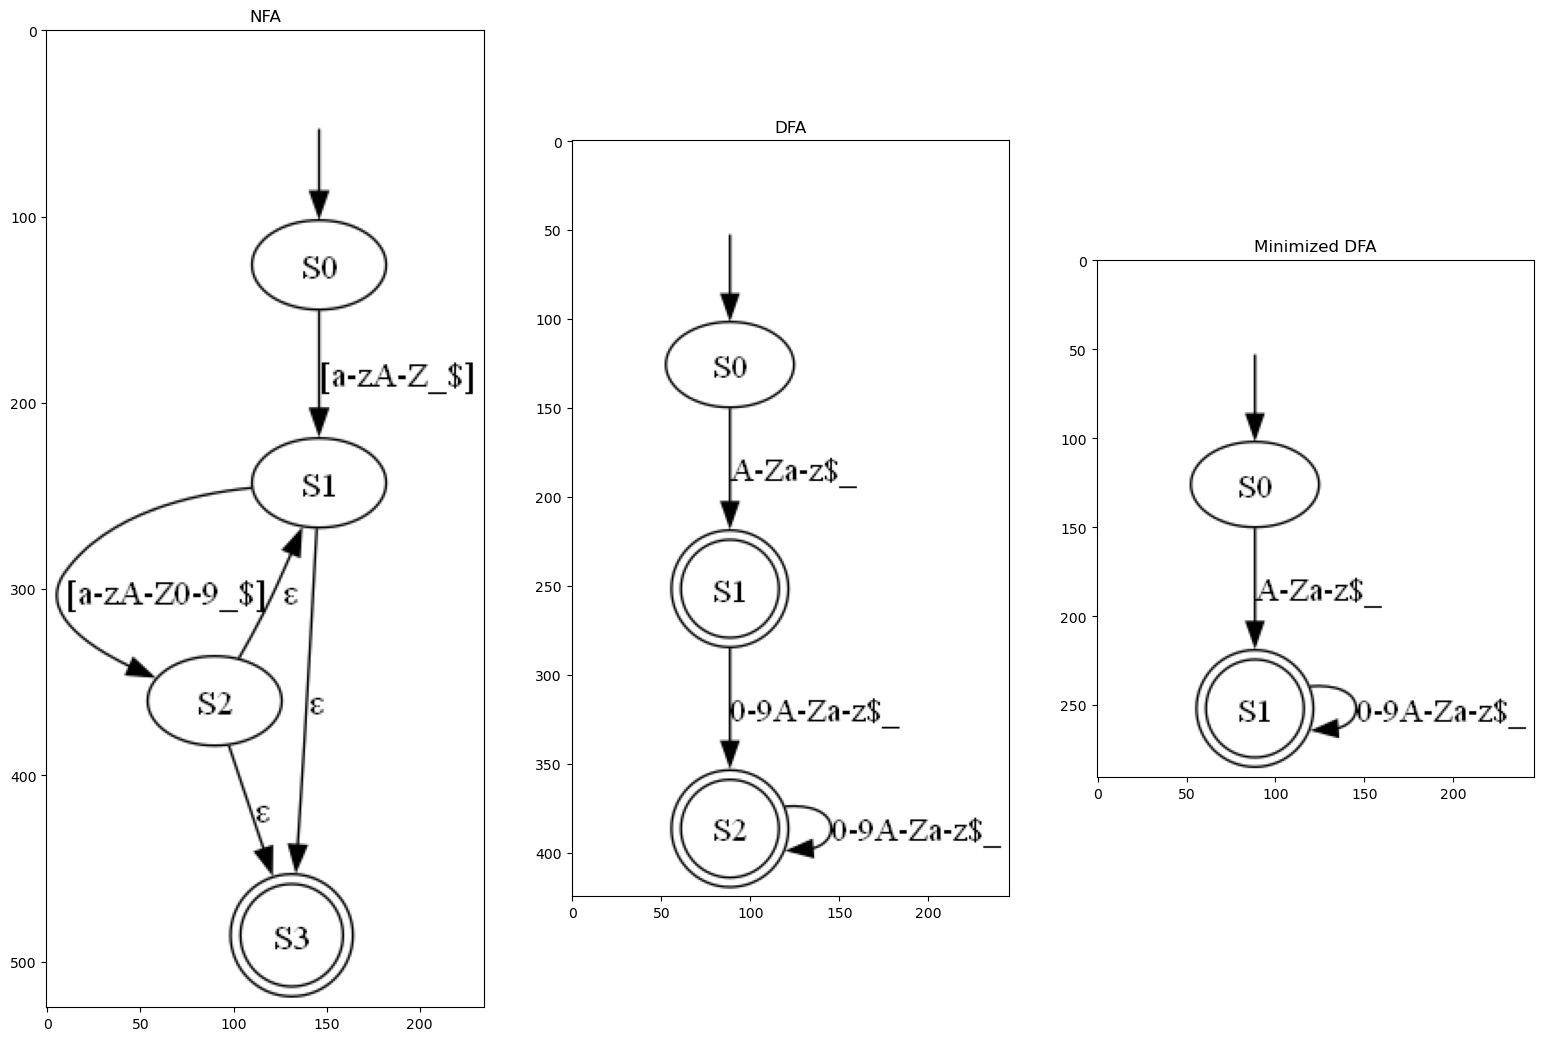

In [120]:
test2 = "[a-zA-Z_$][a-zA-Z0-9_$]*"
NFA_DFA(test2, "test2")

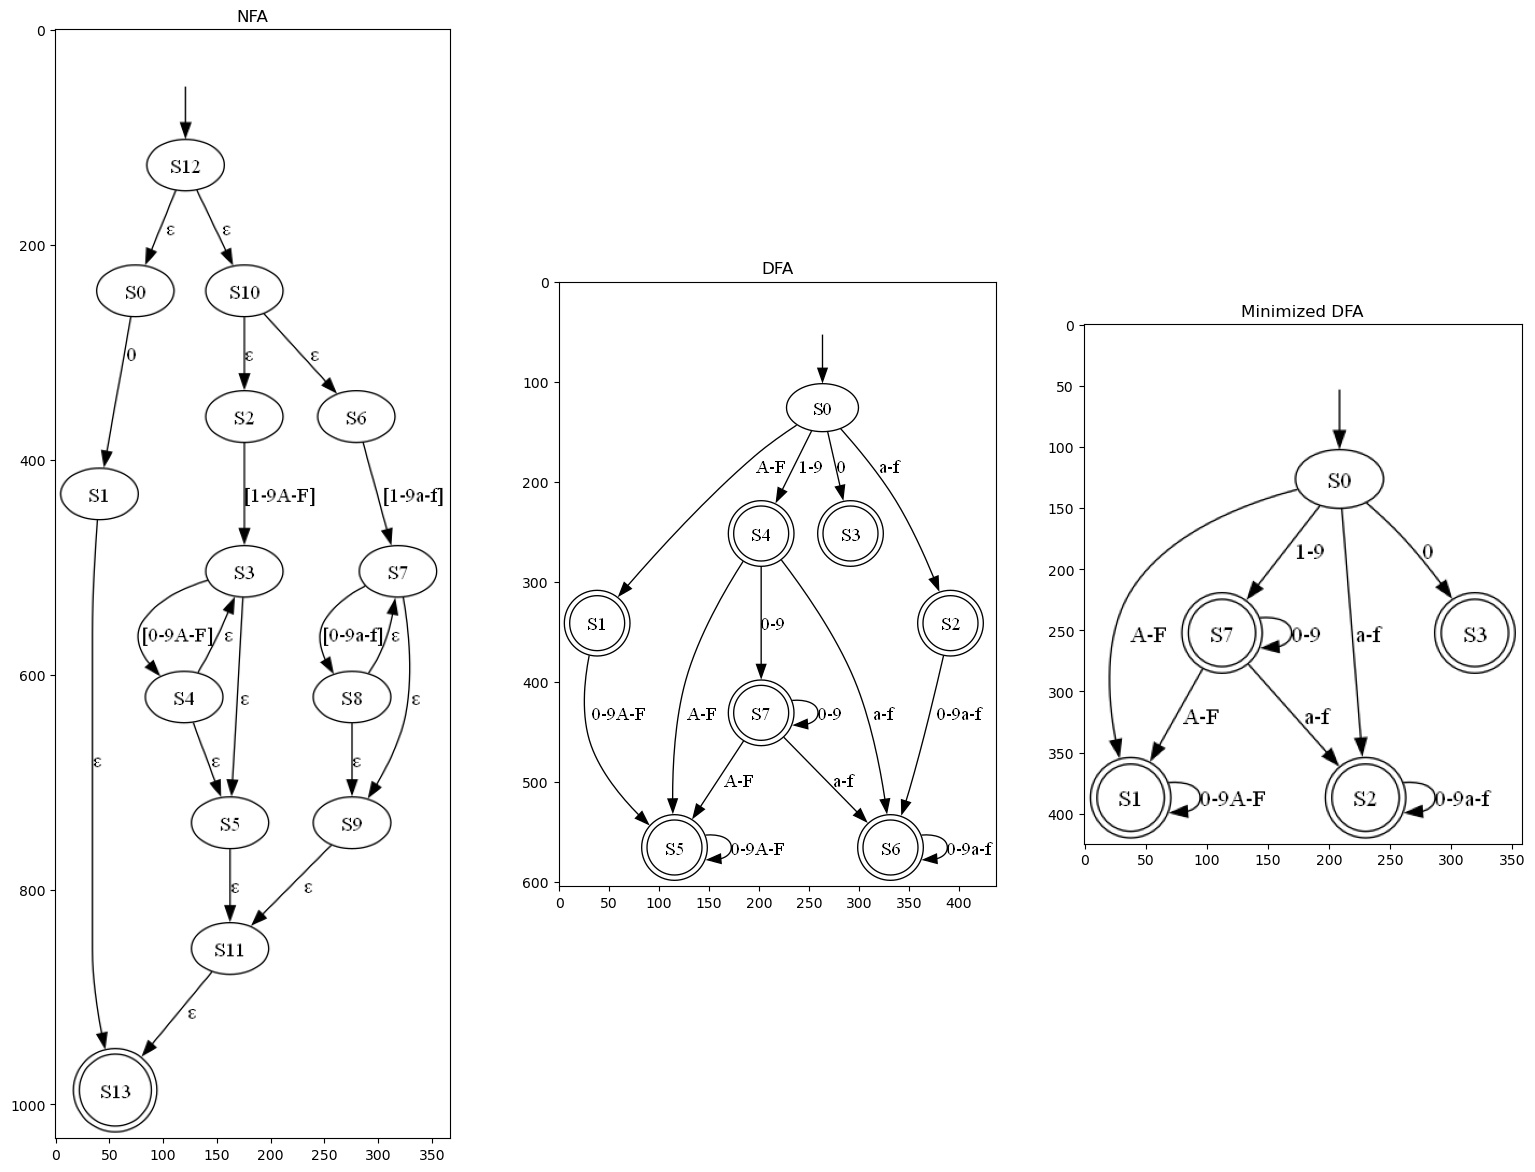

In [121]:
test3 = "0|[1-9A-F][0-9A-F]*|[1-9a-f][0-9a-f]*"
NFA_DFA(test3, "test3")

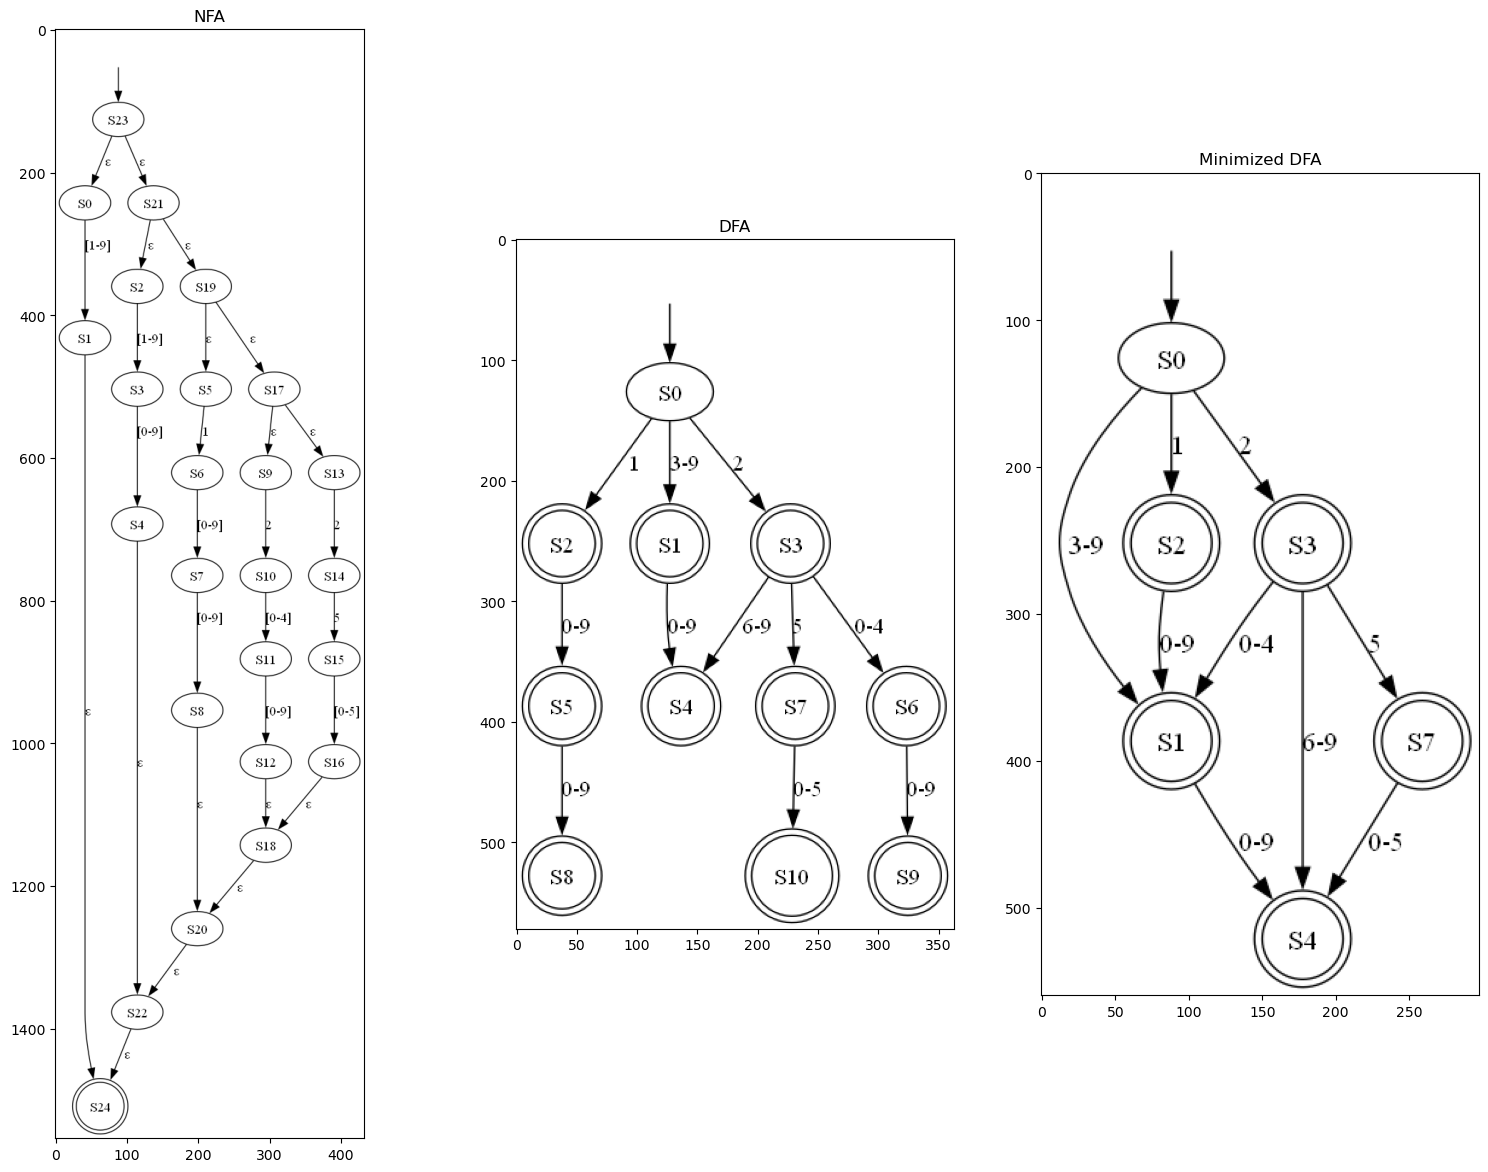

In [123]:
test5 = "[1-9]|[1-9][0-9]|1[0-9][0-9]|2[0-4][0-9]|25[0-5]"
NFA_DFA(test5, "test5")

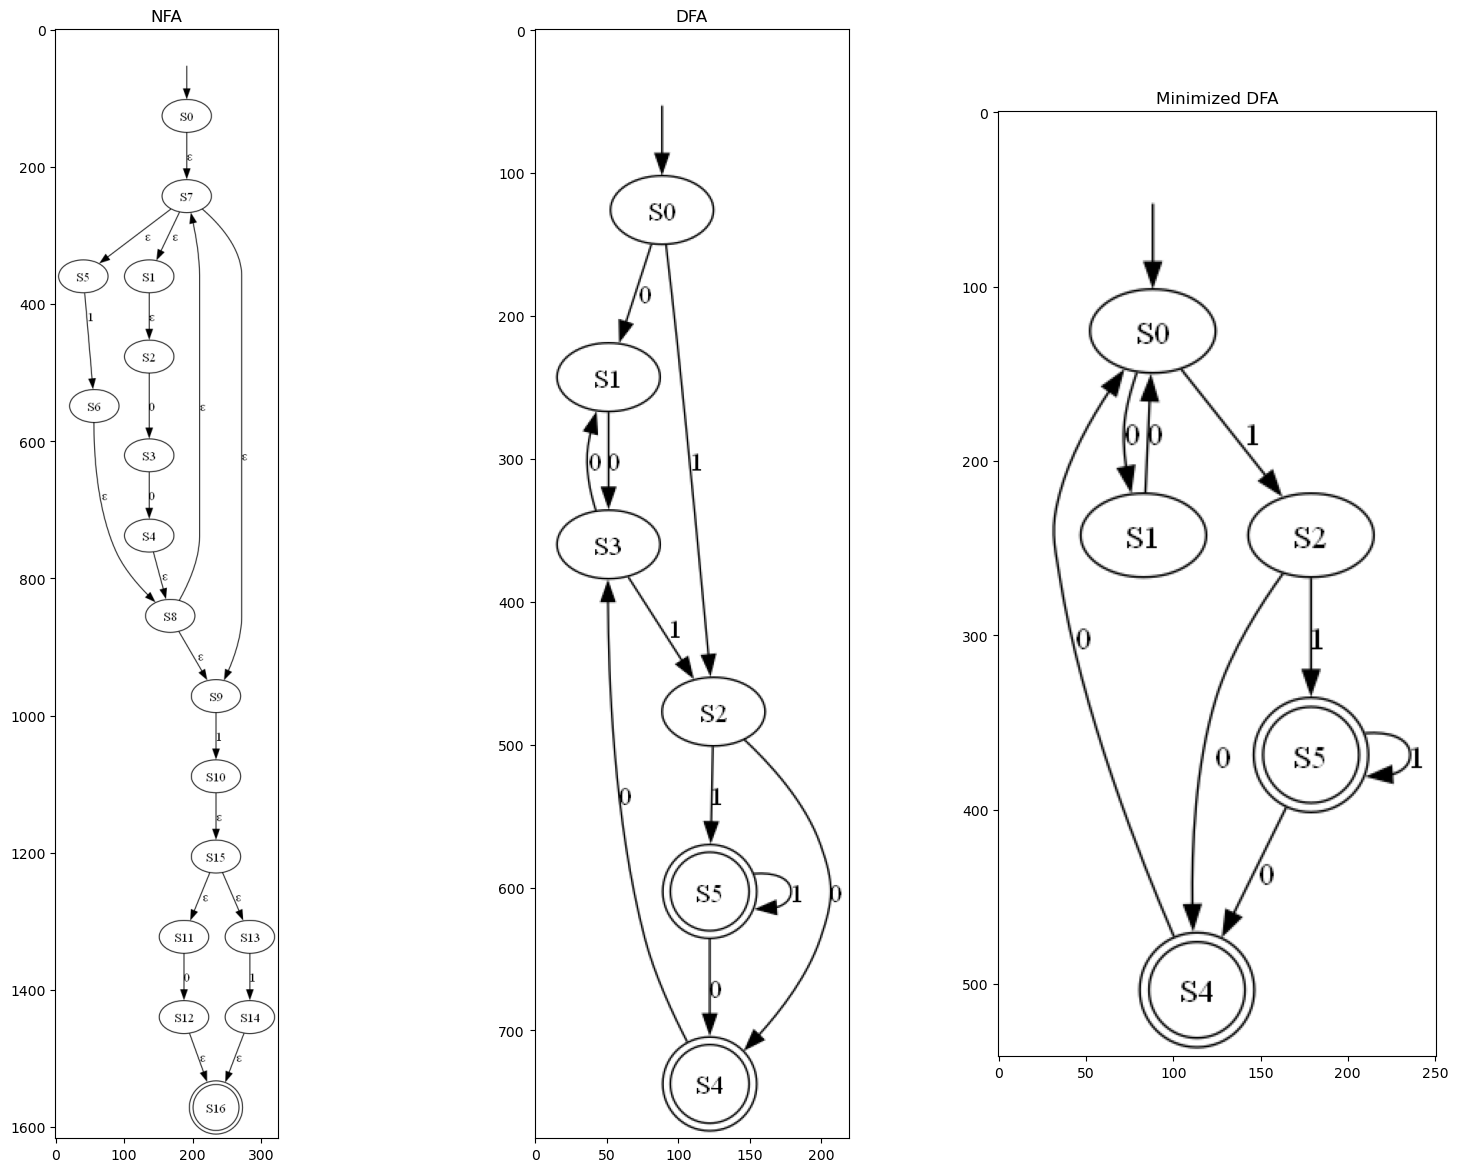

In [124]:
test6 = "((00)|1)*1(0|1)"
NFA_DFA(test6, "test6")

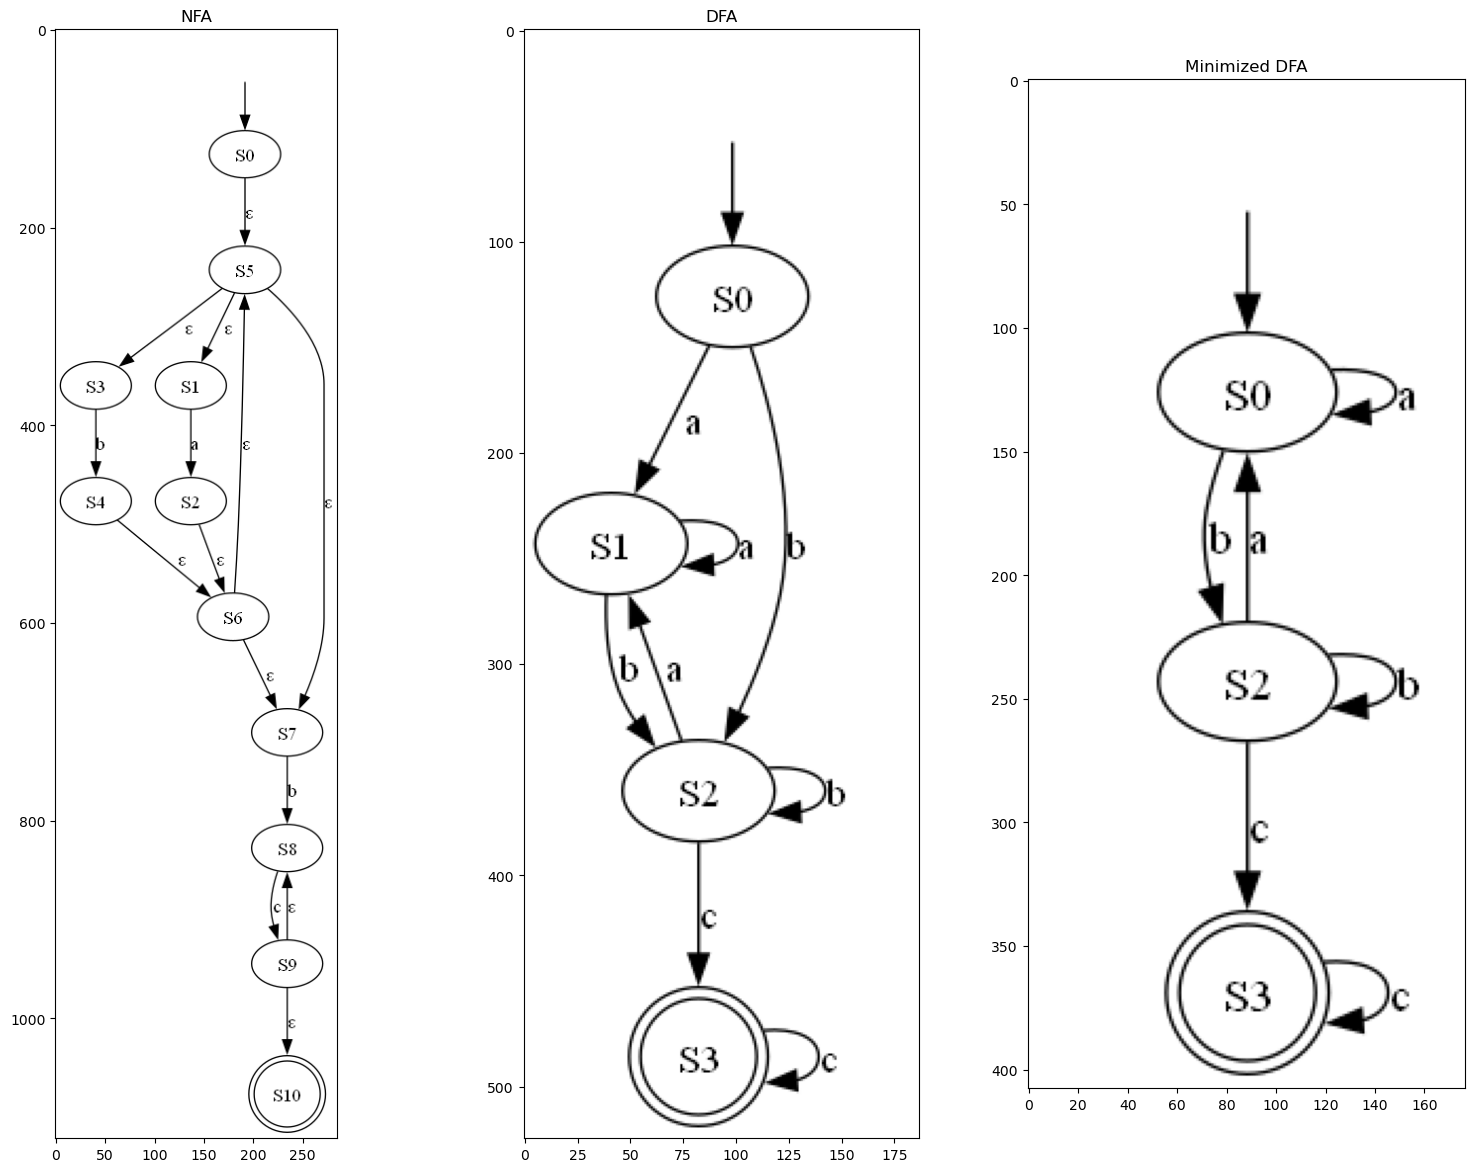

In [125]:
test7 = "(a|b)*bc+"
NFA_DFA(test7, "test7")

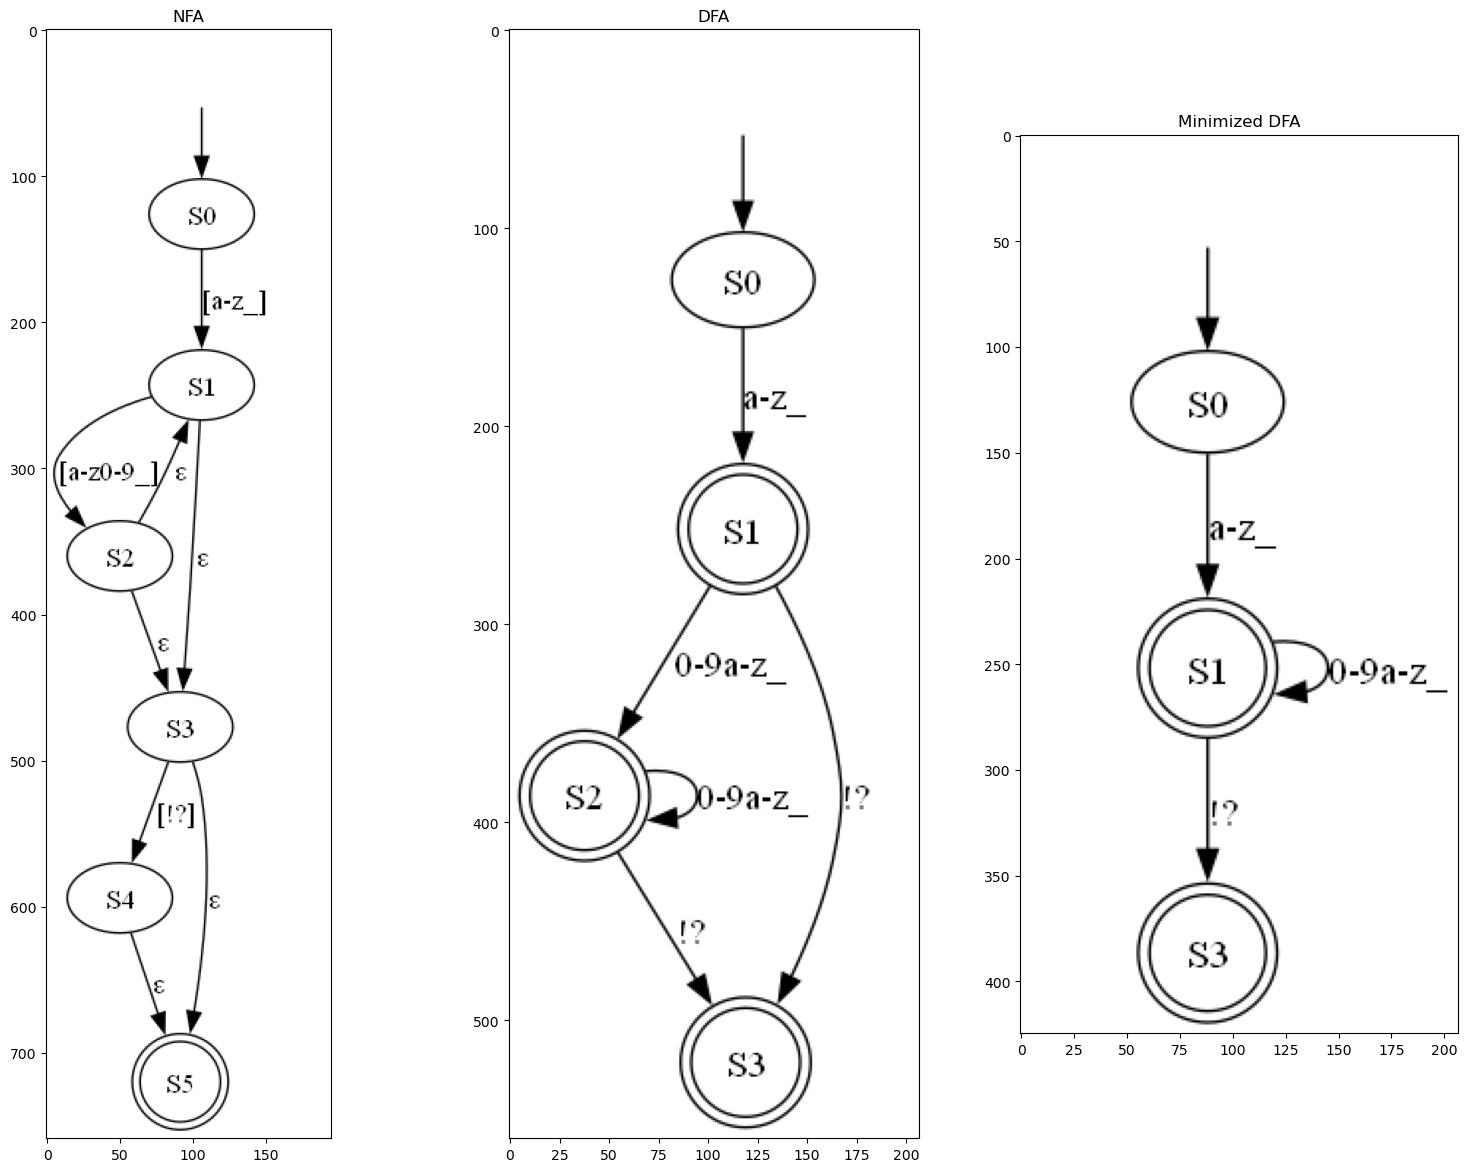

In [126]:
test8 = "[a-z_][a-z0-9_]*[!?]?"
NFA_DFA(test8, "test8")